# Pilot Separation Diagnostics
This notebook visualizes the original mix versus the speech-only render produced by the Demucs + DNS64 pipeline.

In [24]:
from tabulate import tabulate

metrics_path = Path('../artifacts/eval/metrics.csv')
if not metrics_path.exists():
    raise FileNotFoundError(f'Metrics file not found at {metrics_path}')

metrics_df = pd.read_csv(metrics_path, header=None, names=['metric', 'value'])

def parse_value(val):
    if isinstance(val, str):
        stripped = val.strip()
        if stripped.startswith('{') and stripped.endswith('}'):
            try:
                parsed = json.loads(stripped)
                if isinstance(parsed, dict):
                    return parsed
            except json.JSONDecodeError:
                return val
    return val

metrics_df['value'] = metrics_df['value'].apply(parse_value)

expanded_rows = []
for _, row in metrics_df.iterrows():
    value = row['value']
    if isinstance(value, dict):
        for sub_key, sub_val in value.items():
            expanded_rows.append({'metric': f"{row['metric']}[{sub_key}]", 'value': sub_val})
    else:
        expanded_rows.append({'metric': row['metric'], 'value': value})

display_df = pd.DataFrame(expanded_rows)
print(tabulate(display_df, headers='keys', tablefmt='github', showindex=False))

| metric                               | value                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [22]:
!pip install librosa matplotlib numpy soundfile pandas tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 14.0 MB/s  0:00:00m0:00:0100:01━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.3 MB ? eta -:--:--
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 14.0 MB/s  0:00:00
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pandas]

In [23]:
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pathlib import Path

set_matplotlib_formats('svg')

orig_path = Path('../data/text_batched_generated.wav')
clean_path = Path('../artifacts/text_batched_generated__speech_only.wav')
orig, sr = librosa.load(orig_path, sr=None)
clean, _ = librosa.load(clean_path, sr=sr)

min_len = min(len(orig), len(clean))
if len(orig) != len(clean):
    orig = orig[:min_len]
    clean = clean[:min_len]
    print(f'Aligned signals to {min_len/sr:.2f}s for plotting consistency')

time = np.arange(min_len) / sr
print(f'Sample rate: {sr} Hz, duration: {min_len/sr:.2f}s after alignment')

Aligned signals to 79.33s for plotting consistency
Sample rate: 24000 Hz, duration: 79.33s after alignment


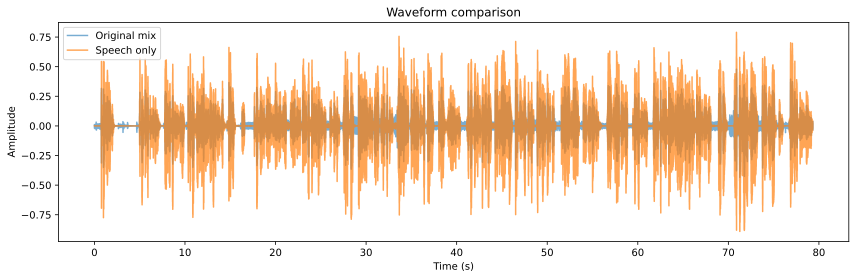

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(time, orig, alpha=0.6, label='Original mix')
plt.plot(time, clean, alpha=0.7, label='Speech only')
plt.title('Waveform comparison')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()

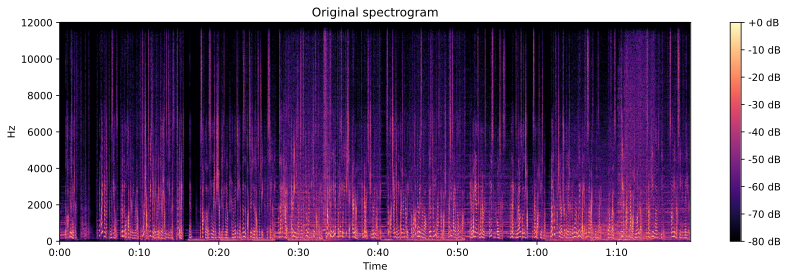

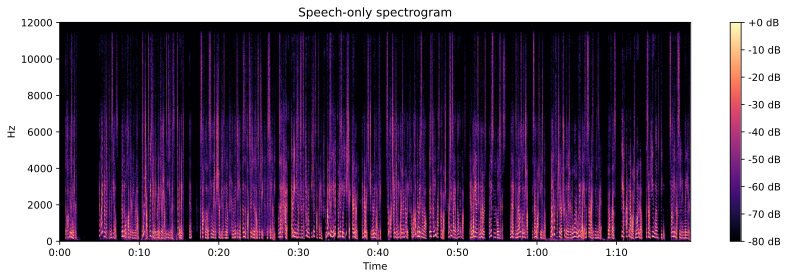

In [17]:
def show_spec(signal, title):
    S = librosa.stft(signal, n_fft=2048, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, hop_length=512, cmap='magma', x_axis='time', y_axis='hz')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

show_spec(orig, 'Original spectrogram')
show_spec(clean, 'Speech-only spectrogram')

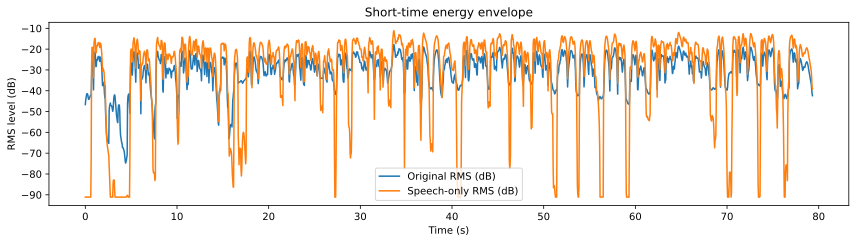

In [18]:
frame_length = 4096
hop_length = 1024
rms_orig = librosa.feature.rms(y=orig, frame_length=frame_length, hop_length=hop_length, center=True)[0]
rms_clean = librosa.feature.rms(y=clean, frame_length=frame_length, hop_length=hop_length, center=True)[0]
rms_time = librosa.frames_to_time(np.arange(len(rms_orig)), sr=sr, hop_length=hop_length)
plt.figure(figsize=(12, 3.5))
plt.plot(rms_time, librosa.amplitude_to_db(rms_orig), label='Original RMS (dB)')
plt.plot(rms_time, librosa.amplitude_to_db(rms_clean), label='Speech-only RMS (dB)')
plt.title('Short-time energy envelope')
plt.xlabel('Time (s)')
plt.ylabel('RMS level (dB)')
plt.legend()
plt.tight_layout()
plt.show()

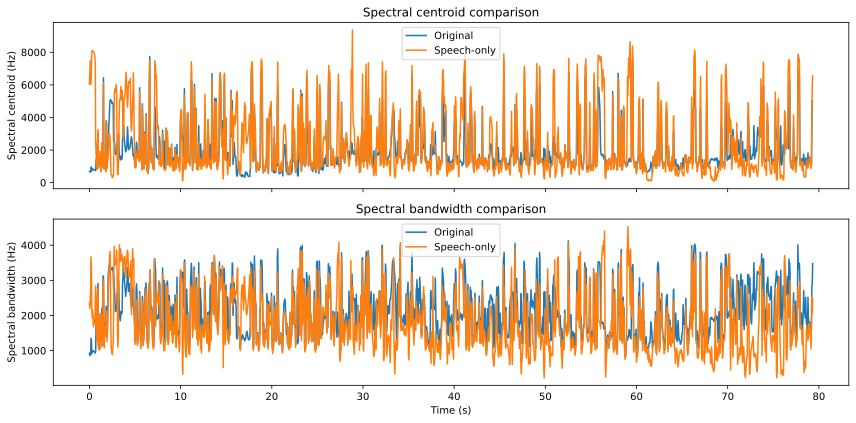

In [19]:
spectral_centroid_orig = librosa.feature.spectral_centroid(y=orig, sr=sr, hop_length=hop_length)[0]
spectral_centroid_clean = librosa.feature.spectral_centroid(y=clean, sr=sr, hop_length=hop_length)[0]
spectral_bw_orig = librosa.feature.spectral_bandwidth(y=orig, sr=sr, hop_length=hop_length)[0]
spectral_bw_clean = librosa.feature.spectral_bandwidth(y=clean, sr=sr, hop_length=hop_length)[0]
centroid_time = librosa.frames_to_time(np.arange(len(spectral_centroid_orig)), sr=sr, hop_length=hop_length)
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax[0].plot(centroid_time, spectral_centroid_orig, label='Original')
ax[0].plot(centroid_time, spectral_centroid_clean, label='Speech-only')
ax[0].set_ylabel('Spectral centroid (Hz)')
ax[0].set_title('Spectral centroid comparison')
ax[0].legend()
ax[1].plot(centroid_time, spectral_bw_orig, label='Original')
ax[1].plot(centroid_time, spectral_bw_clean, label='Speech-only')
ax[1].set_ylabel('Spectral bandwidth (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Spectral bandwidth comparison')
ax[1].legend()
fig.tight_layout()
plt.show()

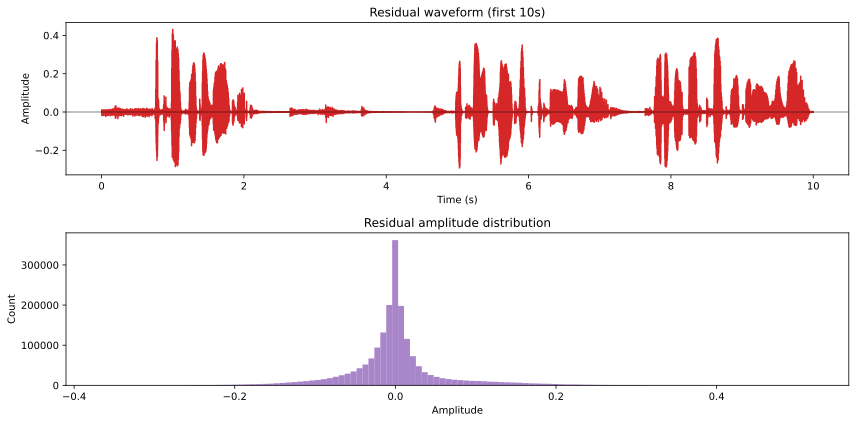

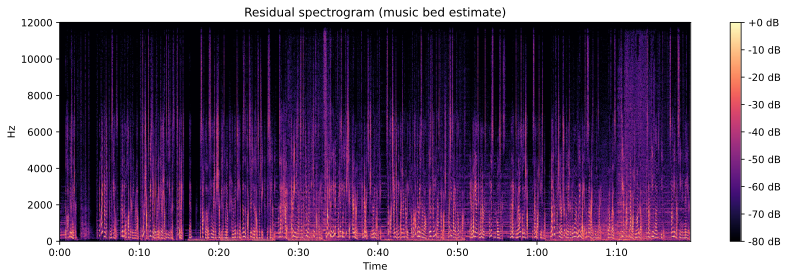

In [20]:
residual = orig - clean
snippet_duration = 10
snippet = residual[: int(snippet_duration * sr)]
snippet_time = np.arange(len(snippet)) / sr
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(snippet_time, snippet, color='tab:red')
ax[0].set_title(f'Residual waveform (first {snippet_duration}s)')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].axhline(0, color='black', linewidth=0.8, alpha=0.6)
ax[1].hist(residual, bins=120, color='tab:purple', alpha=0.8)
ax[1].set_title('Residual amplitude distribution')
ax[1].set_xlabel('Amplitude')
ax[1].set_ylabel('Count')
fig.tight_layout()
plt.show()

show_spec(residual, 'Residual spectrogram (music bed estimate)')

## Evaluation Metrics Snapshot
Tabulated ASR and loudness diagnostics pulled from `artifacts/eval/metrics.csv`.